In [2]:
import logging
from math import floor

from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path

import pandas as pd
import os
import numpy as np

logger = logging.getLogger(__name__)

In [3]:

IMAGE_INPUT_WIDTH=160
IMAGE_INPUT_HEIGHT=120
# This discards number of pixels from the top after scaling
TOP_MARGIN_IN_PIXELS=8


col_img = 'image'
col_steering = 'msg.steering'
col_throttle = 'msg.throttle'
col_image_ts = 'image_timestamp'
col_steernig_ts = 'steering_timestamp'
col_steering_scaled = 'steering_scaled'
col_throttle_scaled = 'throttle_scaled'

base_dir = Path("./data/")
def read_csv(path):
    df = pd.read_csv(path)
    for col in [col_img, col_steering, col_throttle, col_image_ts, col_steernig_ts]:
        assert col in df.columns, f'missing {col} in {path}'
    return df

# Read files and concatenate them

In [4]:
def load_and_merge_csvs(paths_csv):
    print('Loading {} csvs:\n{}'.format(len(paths_csv), '\n'.join(str(p) for p in paths_csv)))
    csvs = [read_csv(str(path)) for path in paths_csv]
    df = pd.concat(csvs, axis=0, ignore_index=True)
    print(f'loaded {df.shape}')
    return df

db_names =  [
        "sergem_robocar_20191003_v2", 
        "sergem_robocar_20191009_v2",
        "sergem_robocar_20191106",
    ]
dfs = {
    db_name: load_and_merge_csvs(sorted(base_dir.glob(f"{db_name}/*.csv")))
    for db_name in db_names
}
# df1 = load_and_merge_csvs(sorted(base_dir.glob("sergem_robocar_20191003_v2/*.csv")))
# df2 = load_and_merge_csvs(sorted(base_dir.glob("*201911*/*.csv")))

Loading 12 csvs:
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-16-35-11_0_f.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-16-38-11_1.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-16-52-47_0_f.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-16-55-47_1.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-16-58-47_2_f.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-01-47_3_f.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-04-47_4.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-07-47_5.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-10-47_6.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-13-47_7.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-16-47_8.csv
data/sergem_robocar_20191003_v2/robocar_recording__2016-02-11-17-19-47_9.csv
loaded (17587, 5)
Loading 3 csvs:
data/sergem_roboc

In [5]:
dfs[db_names[0]].head()

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle
0,1455208587539773695,1455208587542355136,robocar_recording__2016-02-11-16-35-11_0_f/fra...,1372,1732
1,1455208587637106047,1455208587642769706,robocar_recording__2016-02-11-16-35-11_0_f/fra...,1372,1736
2,1455208587738445506,1455208587743968176,robocar_recording__2016-02-11-16-35-11_0_f/fra...,1368,1756
3,1455208587837093786,1455208587842914892,robocar_recording__2016-02-11-16-35-11_0_f/fra...,1348,1824
4,1455208587937189035,1455208587944909971,robocar_recording__2016-02-11-16-35-11_0_f/fra...,1336,1828


In [6]:
dfs[db_names[2]].head()

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle
0,1455211065290544335,1455211065290725636,robocar_recording__2016-02-11-17-16-01_f/frame...,1496,1844
1,1455211065390654605,1455211065391509495,robocar_recording__2016-02-11-17-16-01_f/frame...,1480,1820
2,1455211065494394017,1455211065502565942,robocar_recording__2016-02-11-17-16-01_f/frame...,1460,1816
3,1455211065591689462,1455211065592365759,robocar_recording__2016-02-11-17-16-01_f/frame...,1460,1820
4,1455211065693746541,1455211065695147782,robocar_recording__2016-02-11-17-16-01_f/frame...,1464,1864


# defining scaling
radio pwm has a certain range and the data is recorded as is. Now it's time to preprocess it to make it generic

In [7]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"



def plot_ranges(column, val_min=None, val_zero=None, val_max=None, update_layout_kwargs={}):
    graphs =[
        go.Scatter(x=column.index, y=column, mode='lines'),
    ]
    if val_min is not None:
        graphs.append(go.Scatter(x=column.index, y=val_min, mode='lines', name='min'))
    if val_zero is not None:
        graphs.append(go.Scatter(x=column.index, y=val_zero, mode='lines', name='zero',
                  line=dict(width=4,dash='dash')),
        )
    if val_max is not None:
        graphs.append(go.Scatter(x=column.index, y=val_max, mode='lines', name='max'),)
    fig = go.Figure(data=graphs)
    fig.update_layout(**update_layout_kwargs)
    fig.show()

In [8]:
def zeros_series_like(series):
    return series * 0

In [9]:
def rescale_steering(df,
            st_zero = 1372,
                     name='',
):
    df = df.copy()
    st_min, st_max = df[col_steering].quantile(q=[0.01, 0.99])
    
    print(st_min, st_max)
    
    zero_col = zeros_series_like(df[col_steering])
    
    plot_ranges(
        df[col_steering], 
        zero_col + st_min, 
        zero_col + st_zero, 
        zero_col + st_max, 
        update_layout_kwargs = {'title': 'steering initial' + name}
    )

    df[col_steering_scaled] = np.clip(np.interp(df[col_steering], (st_min, st_zero, st_max), (-1, 0, +1)), -1, 1)
    plot_ranges(
        df[col_steering_scaled], 
        zero_col + -1, 
        zero_col + 0, 
        zero_col + 1, 
        update_layout_kwargs = {'title': 'steering scaled ' + name}
    )
    return df[col_steering_scaled]


def rescale_throttle(
    df,
    shift_th_min = -1000, # check it with your data
    shift_th_zero = -500,
    window_size_max_throttle = 700,
    name='',
        
):
    df = df.copy()
    th_max = df[col_throttle].rolling(window_size_max_throttle, center=True, min_periods=1).quantile(quantile=0.98)
    th_min = th_max + shift_th_min
    th_zero = th_max + shift_th_zero
    
    zero_col = zeros_series_like(df[col_steering])

    plot_ranges(
        df[col_throttle], 
        zero_col + th_min, 
        zero_col + th_zero, 
        zero_col + th_max,
        update_layout_kwargs = {'title': 'throttle initial ' + name}
    )

    df[col_throttle_scaled] = 0
    df[col_throttle_scaled] = (df[col_throttle] - th_min) / (th_max - th_min)
    df[col_throttle_scaled] = df[col_throttle_scaled] * 2 - 1
    df[col_throttle_scaled] = df[col_throttle_scaled].clip(-1., 1.)
    
    plot_ranges(
        df[col_throttle_scaled], 
        zero_col + -1, 
        zero_col + 0, 
        zero_col + 1, 
        update_layout_kwargs = {'title': 'throttle scaled ' + name}
    )
    return df[col_throttle_scaled]

In [31]:
def rescale(df, name=''):
    df = df.copy()
    df[col_steering_scaled] = rescale_steering(df, name=name)
    df[col_throttle_scaled] = rescale_throttle(df, name=name)
    df = df.set_index(df[col_image_ts])
    return df

In [32]:
dfs_scaled = { db_name: rescale(df, name=db_name) for db_name, df in dfs.items()} 

1144.0 1604.0
1144.0 1604.0
1168.0 1584.0


In [33]:
df = dfs_scaled[db_names[2]]
go.Figure(data=[
    go.Scatter(x=df.index, y=df[col_steering_scaled], mode='lines', name='steeing_scaled'),
    go.Scatter(x=df.index, y=df[col_throttle_scaled], mode='lines', name='throttle_scaled'),
]).show()

#### Discard if 

1) if there is a reverse in the future 3 sec

2) no throttle and no steering


In [34]:
def find_moments_before_reverse(
    df,
    col_target = 'reverse_in_the_future',
    threshold_ns = 3 * 1e9
):
    df = df.copy()
    df[col_target] = 0

    i_nearest_reverse = len(df) - 1
    
    res = []
    
    def reverse_is_close_to_current(i_nearest_reverse, i_cur):
        return df.iloc[i_nearest_reverse][col_image_ts] - df.iloc[i_cur][col_image_ts] < threshold_ns
    
    for i_cur in range(len(df) - 1, -1, -1):
        if df.iloc[i_cur][col_throttle_scaled] < 0: 
            i_nearest_reverse = i_cur

        val = 1 if reverse_is_close_to_current(i_nearest_reverse, i_cur) else 0
        res.append(val)
    df[col_target] = res[::-1]
    return df[col_target]


In [35]:
throttle_idle_threshold = 0.3
 
time_bofore_reverse_ns = 3*1e9
for db_name in db_names:
    df = dfs_scaled[db_name]
    df['reverse_in_the_future'] = find_moments_before_reverse(df, threshold_ns=time_bofore_reverse_ns)
    df['idle'] = (
        (df[col_throttle_scaled].abs() < throttle_idle_threshold)
    ) * 1
    
    df['goodness'] = ((df['reverse_in_the_future'] == 0) & (df['idle'] == 0)) * 1

In [36]:
# df2_s[df2_s['reverse_in_the_future'] == 0]

In [37]:
df = dfs_scaled[db_names[1]]
go.Figure(data=[
    go.Scatter(x=df.index, y=df[col_steering_scaled], mode='lines', name='steeing_scaled'),
    go.Scatter(x=df.index, y=df[col_throttle_scaled], mode='lines', name='throttle_scaled'),
    go.Scatter(x=df.index, y=df['reverse_in_the_future'], mode='lines', name='reverse_in_the_future',
              line=dict(width=1,dash='dash')),
    go.Scatter(x=df.index, y=df['idle'], mode='lines', name='idle',
              line=dict(width=1,dash='dash')),
    go.Scatter(x=df.index, y=df['goodness'], mode='lines', name='goodness',
              line=dict(width=2,dash='dash')),

]).show()

## Saving filtered data

In [38]:
for db_name in db_names:
    df = dfs_scaled[db_name].copy()
    df[col_img] = df[col_img].map(lambda path: str(Path(db_name) / path))
    df = df[df['goodness'] != 0]
    df.to_csv(base_dir / db_name / f"{db_name}.filteredcsv", index=False)

In [39]:
# df['image'].iloc[0]

# Loading filtered data 

In [40]:
filtered_csv_paths = sorted(base_dir.glob("**/*.filteredcsv"))
filtered_csv_paths

[PosixPath('data/sergem_robocar_20191003_v2/sergem_robocar_20191003_v2.filteredcsv'),
 PosixPath('data/sergem_robocar_20191009_v2/sergem_robocar_20191009_v2.filteredcsv'),
 PosixPath('data/sergem_robocar_20191106/sergem_robocar_20191106.filteredcsv')]

In [41]:
df_filtered = load_and_merge_csvs(filtered_csv_paths)

Loading 3 csvs:
data/sergem_robocar_20191003_v2/sergem_robocar_20191003_v2.filteredcsv
data/sergem_robocar_20191009_v2/sergem_robocar_20191009_v2.filteredcsv
data/sergem_robocar_20191106/sergem_robocar_20191106.filteredcsv
loaded (38958, 10)


In [42]:
df_filtered.head()

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle,steering_scaled,throttle_scaled,reverse_in_the_future,idle,goodness
0,1455208587539773695,1455208587542355136,sergem_robocar_20191003_v2/robocar_recording__...,1372,1732,0.000000,0.560,0,0,1
1,1455208587637106047,1455208587642769706,sergem_robocar_20191003_v2/robocar_recording__...,1372,1736,0.000000,0.568,0,0,1
2,1455208587738445506,1455208587743968176,sergem_robocar_20191003_v2/robocar_recording__...,1368,1756,-0.017544,0.608,0,0,1
3,1455208587837093786,1455208587842914892,sergem_robocar_20191003_v2/robocar_recording__...,1348,1824,-0.105263,0.744,0,0,1
4,1455208587937189035,1455208587944909971,sergem_robocar_20191003_v2/robocar_recording__...,1336,1828,-0.157895,0.752,0,0,1


## split to training and validataion by indexes
It's just a proxy for time

In [65]:
is_valid = df_filtered.index % 1000 < 200
df_filtered['validation'] = is_valid * 1


In [66]:
go.Figure(data=[
    go.Scatter(x=df_filtered.index, y=df_filtered[col_steering_scaled], mode='lines', name='steeing_scaled'),
    go.Scatter(x=df_filtered.index, y=df_filtered[col_throttle_scaled], mode='lines', name='throttle_scaled'),
    go.Scatter(x=df_filtered.index, y=df_filtered['validation'], mode='lines', name='validation'),
]).show()

In [67]:
# shuffle to avoid issue: https://github.com/keras-team/keras-preprocessing/issues/205
df_train = df_filtered[df_filtered['validation'] == 0].sample(frac=1) 
df_val = df_filtered[df_filtered['validation'] == 1]
df_train.shape, df_val.shape

((31158, 11), (7800, 11))

# Training

In [74]:
datagen=ImageDataGenerator(rescale=1./255)

def create_generator(df):
    return datagen.flow_from_dataframe(dataframe=df, directory=str(base_dir),
        x_col=col_img,
        y_col=[col_steering_scaled, col_throttle_scaled],
        class_mode="multi_output",
        target_size=(IMAGE_INPUT_HEIGHT, IMAGE_INPUT_WIDTH),
        batch_size=32,
        shuffle=True,
    )
train_generator=create_generator(df_train)
val_generator=create_generator(df_val)


Found 31158 validated image filenames.
Found 7800 validated image filenames.


In [75]:
def visualize(imgs, y=None, pred=None):
    def format_(arr, idx):
        if arr is None:
            return "-"
        return ' '.join(['{:.3f}'.format(a.ravel()[idx]) for a in arr])
        
    _, axes = plt.subplots(8, 4, squeeze=False, figsize=(15,20), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        
        text = "y {} \npred {}".format(format_(y, i), format_(pred, i))
        ax.text(20, 20, text, color='cyan')

In [76]:
np.set_printoptions(precision=3)

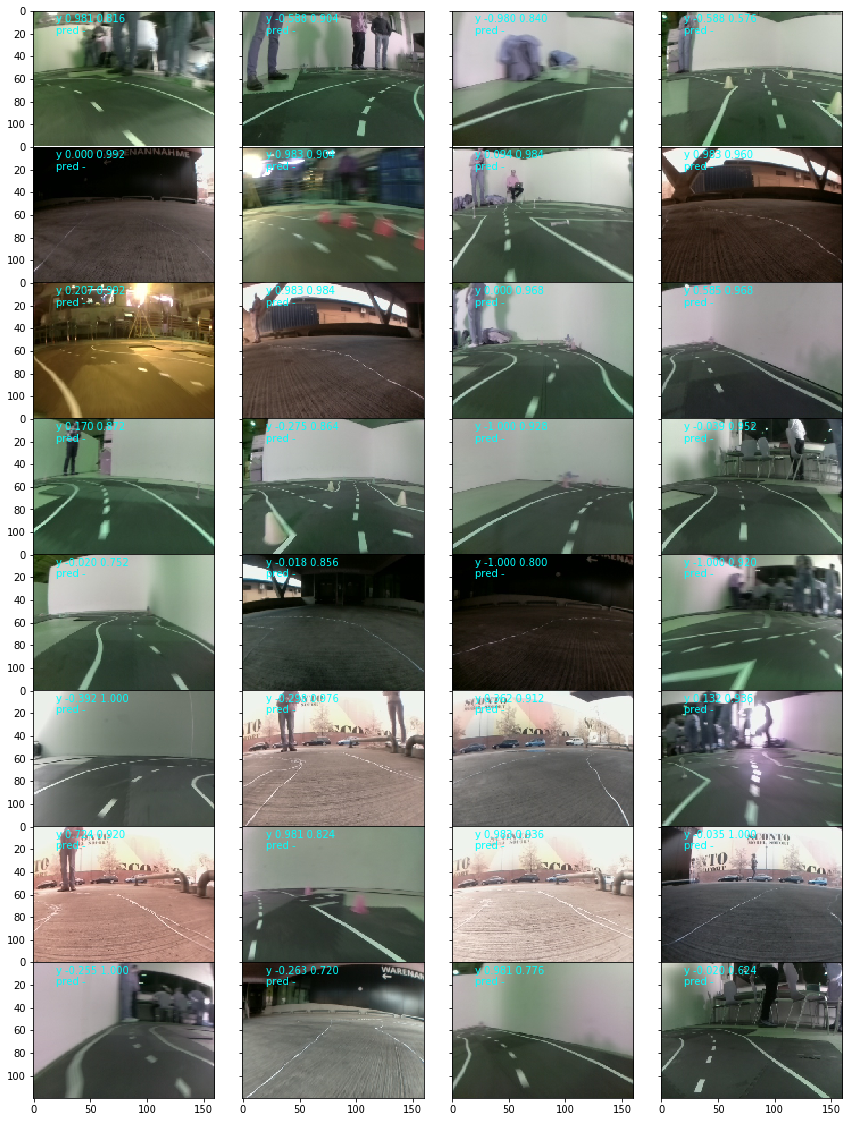

In [77]:
dbg_imgs, dbg_y = train_generator.next()
visualize(dbg_imgs, dbg_y)

In [80]:
dbg_y

[array([ 0.981, -0.588, -0.98 , -0.588,  0.   ,  0.983,  0.094,  0.983,
         0.207,  0.983,  0.   ,  0.585,  0.17 , -0.275, -1.   , -0.039,
        -0.02 , -0.018, -1.   , -1.   , -0.392, -0.298,  0.362,  0.132,
         0.724,  0.981,  0.983, -0.035, -0.255, -0.263,  0.981, -0.02 ]),
 array([0.816, 0.904, 0.84 , 0.576, 0.992, 0.904, 0.984, 0.96 , 0.992,
        0.984, 0.968, 0.968, 0.872, 0.864, 0.928, 0.952, 0.752, 0.856,
        0.8  , 0.92 , 1.   , 0.976, 0.912, 0.936, 0.92 , 0.824, 0.936,
        1.   , 1.   , 0.72 , 0.776, 0.624])]

In [81]:
def default_linear():
    img_in = Input(shape=(120, 160, 3), name='img_in')
    x = img_in

    # Convolution2D class name is an alias for Conv2D
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    x = Dense(units=50, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)

    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[
        angle_out, 
        throttle_out
    ])

    model.compile(optimizer='adam',
                  loss={
                      'angle_out': 'mean_squared_error',
                      'throttle_out': 'mean_squared_error'
                  },
                  loss_weights={
                      'angle_out': 0.95, 
                      'throttle_out': .05
                  }
                 )

    return model

In [82]:
model = default_linear()

W1117 19:13:55.235192 140713768478528 deprecation.py:506] From /home/s/work/car/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [83]:
use_early_stop = True
epochs = 10
saved_model_path = "./models/linear.model"
verbose = True
min_delta=.0005
patience=5

In [84]:
len(train_generator), train_generator.n, train_generator.batch_size, 40*32

(974, 31158, 32, 1280)

In [85]:
save_best = ModelCheckpoint(saved_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best]

if use_early_stop:
    callbacks_list.append(early_stop)

hist = model.fit_generator(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    callbacks=callbacks_list)

Epoch 1/10
973/974 [============================>.] - ETA: 0s - loss: 0.1682 - angle_out_loss: 0.1754 - throttle_out_loss: 0.0321
Epoch 00001: val_loss improved from inf to 0.12161, saving model to ./models/linear.model
974/974 [==============================] - 148s 152ms/step - loss: 0.1681 - angle_out_loss: 0.1753 - throttle_out_loss: 0.0321 - val_loss: 0.1216 - val_angle_out_loss: 0.1272 - val_throttle_out_loss: 0.0149
Epoch 2/10
973/974 [============================>.] - ETA: 0s - loss: 0.0958 - angle_out_loss: 0.0999 - throttle_out_loss: 0.0179
Epoch 00002: val_loss improved from 0.12161 to 0.10933, saving model to ./models/linear.model
974/974 [==============================] - 150s 154ms/step - loss: 0.0958 - angle_out_loss: 0.0999 - throttle_out_loss: 0.0179 - val_loss: 0.1093 - val_angle_out_loss: 0.1143 - val_throttle_out_loss: 0.0142
Epoch 3/10
973/974 [============================>.] - ETA: 0s - loss: 0.0827 - angle_out_loss: 0.0862 - throttle_out_loss: 0.0161
Epoch 00003:

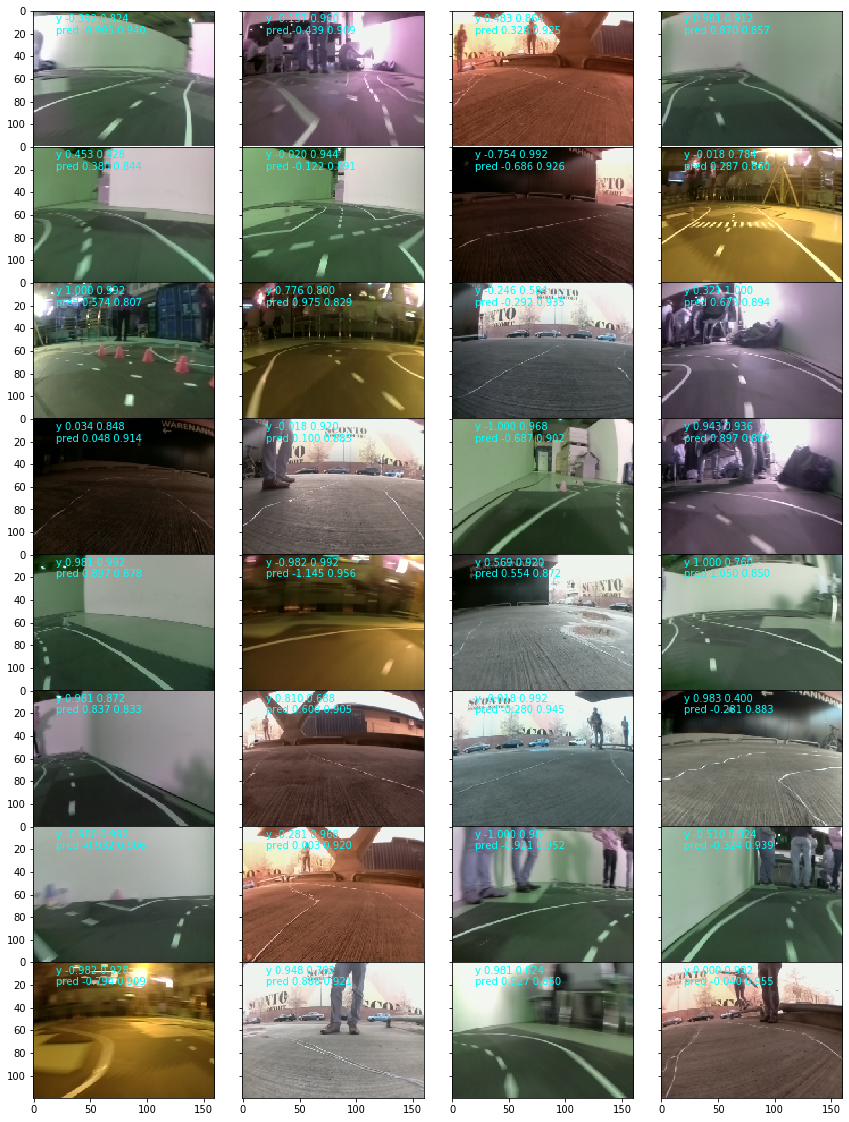

In [89]:
vis_imgs, vis_y = val_generator.next()
vis_pred = model.predict(vis_imgs)
visualize(vis_imgs, vis_y, vis_pred)

In [87]:
vis_y

[array([-1.   ,  0.075, -1.   ,  0.   ,  0.603, -0.228,  0.983, -0.018,
         0.   ,  0.983,  0.   , -0.039,  0.868, -0.922,  0.   , -0.737,
         0.925,  0.302, -0.386, -0.02 , -0.647,  0.603, -0.608,  0.755,
         0.   , -0.439,  0.293,  0.151,  0.981, -0.018,  0.962,  0.983]),
 array([0.848, 0.816, 0.656, 0.992, 0.992, 0.704, 0.648, 0.864, 0.992,
        0.992, 0.96 , 0.816, 0.968, 0.895, 0.936, 0.944, 0.904, 0.976,
        0.888, 0.928, 0.912, 0.672, 0.744, 0.856, 0.824, 0.992, 0.992,
        0.808, 0.968, 1.   , 1.   , 0.992])]

In [88]:
vis_pred

[array([[-0.558],
        [ 0.138],
        [-0.843],
        [ 0.219],
        [ 0.7  ],
        [ 0.103],
        [ 0.665],
        [-0.282],
        [-0.066],
        [ 0.468],
        [ 0.172],
        [ 0.17 ],
        [ 0.644],
        [-0.352],
        [ 0.132],
        [-0.835],
        [ 0.954],
        [ 0.15 ],
        [-0.148],
        [ 0.129],
        [-0.856],
        [ 0.135],
        [-0.029],
        [ 0.662],
        [-0.109],
        [-0.432],
        [ 0.157],
        [ 0.062],
        [ 1.003],
        [ 0.533],
        [ 1.161],
        [ 0.856]], dtype=float32), array([[0.866],
        [0.886],
        [0.92 ],
        [0.847],
        [0.845],
        [0.856],
        [0.918],
        [0.888],
        [0.887],
        [0.848],
        [0.945],
        [0.897],
        [0.873],
        [0.878],
        [0.852],
        [0.919],
        [0.843],
        [0.866],
        [0.937],
        [0.854],
        [0.907],
        [0.837],
        [0.882],
        [0.893],
